In [ ]:
#Import required libraries
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import joblib
from sklearn import metrics
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
from skimage.transform import resize
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
%matplotlib inline
from collections import Counter
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn import metrics
import time

In [ ]:
#mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
# Google Drive path where coursework material is available
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'My_Computer_vision/CV_Coursework/CW_Folder_PG_template/CW_Folder_PG'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['test_functions.ipynb', 'Models', 'Video', 'CW_Dataset', 'Code', 'Test_functions_video.ipynb', 'Copy of test_functions.ipynb', 'FaceDetectionVideo_using_CNN_MObilenet.ipynb', 'Report template.docx', 'test_functions_v3.ipynb']


In [ ]:
import torch

device = torch.device('cpu')

# Code should run on cpu
print(device)

cpu


In [ ]:
#Magic comand to load for automatic loading of modules
#Adapted from Lab
%load_ext autoreload
%autoreload 2

In [ ]:
#import modules located in code directory
#Adapted from lab
import sys
CODE_PATH = os.path.join(GOOGLE_DRIVE_PATH, 'Code')
sys.path.append(CODE_PATH)

In [ ]:
#extracted data from zipped file to copy in Colab
#Code adapted from the lab
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset/CV2024_CW_Dataset.zip')

  # Copy it to Colab
!cp '{zip_path}' .
  # Unzip it
!yes|unzip -q CV2024_CW_Dataset.zip

# Delete zipped version from Colab (not from Drive)
!rm CV2024_CW_Dataset.zip

In [ ]:
#import required functions from Load_data python script to load data
from Load_data import FileNameList,Fetch_text_data, Fetch_images
#FileNameList is the function to collect all the filnames (images and labels)
#Fetch_text_data is a funtion to import all label names from labels folder into the list
#Fetch_images is a function to import all the images from images folder

In [ ]:
test_label_data = Fetch_text_data('test/labels',FileNameList('test/labels','.txt')) #import test labels
train_label_data = Fetch_text_data('train/labels',FileNameList('train/labels','.txt')) # import train labels
test_images_data = Fetch_images('test/images',FileNameList('test/images', '.jpeg')) #import test images
train_images_data = Fetch_images('train/images',FileNameList('train/images', '.jpeg')) #import train images

In [ ]:
Counter(test_label_data) #distribution of data

Counter({'1': 388, '0': 51, '2': 19})

In [ ]:
#transformation to be used in images
transform = transforms.Compose([
    transforms.ToPILImage(),#conversion to PIL images required in DataLoader
    transforms.Resize((128, 128)), #resizing images
    transforms.ToTensor(),#conversion to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) #normalisation
])

In [ ]:
#Experimented with different convolution with differnet kernal, stride and Fully connected layers
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(16 * 29 * 29, 120)  # Update the input size of fc1
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 3)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(x.size(0), -1)  # Flatten the tensor
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

# net = Net()

In [ ]:
#network architecture
class mask_Net(nn.Module):
    def __init__(self):
        super(mask_Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels= 3,out_channels= 32,kernel_size= 3, padding =1) #first convolution layer
        self.pool = nn.MaxPool2d(kernel_size=2,stride= 2)# defined maxpooled layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding =1)#second convolution layer

        self.fc1 = nn.Linear(64*32*32, 64)  # input size of 1st fully connected layer
        self.fc2 = nn.Linear(64, 64) #2nd fully connected layer
        self.fc3 = nn.Linear(64, 3) #output layer with 3 (number of classes are three)

    def forward(self, x): #feed forward network defined
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor for using in fully connected network
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = mask_Net().to(device)

In [ ]:
# mask dataset needed for DataLoader
#partially adapted from the Lab
from torch.utils.data import Dataset, DataLoader
class Mask_Dataset(Dataset):
    def __init__(self, inputs, targets, transform=None):
        self.inputs = inputs
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_data = self.inputs[idx]
        target = int(self.targets[idx])
        if self.transform:
            input_data = self.transform(input_data)
        return input_data, target

In [ ]:
#Not using random division of train and validation data as data is not balanced---Initially considered
#this was adapted from lab (but not using)
# train_dataset = Mask_Dataset(train_images_data, train_label_data, transform=transform)
# train_dataset, val_dataset = random_split(train_dataset, [0.8, 0.2])
# test_dataset = Mask_Dataset(test_images_data, test_label_data, transform=transform)


In [ ]:
Counter(train_label_data)

Counter({'0': 376, '1': 1940, '2': 78})

In [ ]:
# Create the dataset
dataset = Mask_Dataset(train_images_data, train_label_data, transform=transform)
#refered from https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html
#stratified splitting : as data is unbalanced
required_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=21)
train_idx, val_idx = next(required_split.split(train_images_data, train_label_data))

#train and validation dataset with its inputs and target variables
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)

#Test dataset with its inputs and target variables
test_dataset = Mask_Dataset(test_images_data, test_label_data, transform=transform)

In [ ]:
train_label_data[8]

'1'

In [ ]:
#Distribution of data in train and validation dataset
# labels for target variables
labels_train= [train_label_data[i] for i in train_idx]
labels_val = [train_label_data[i] for i in val_idx]

# Count of taret variables
train_counts = Counter(labels_train)
val_counts = Counter(labels_val)

# Print the counts of each class in train and validation dataset
print("Train label counters:")
for label, count in train_counts.items():
    print(f"Label {label}: {count} ")

print("Validation label counters:")
for label, count in val_counts.items():
    print(f"Label {label}: {count} ")

Train label counters:
Label 1: 1552 
Label 0: 301 
Label 2: 62 
Validation label counters:
Label 0: 75 
Label 1: 388 
Label 2: 16 


In [ ]:
# Create data loaders with batch size =32
#Adapted from Lab
#Experimented with different batch size
train_dataloader = DataLoader(dataset=train_dataset, batch_size=32,shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset,batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size= 32, shuffle=False)

In [ ]:
# Set hyperparameters
epochs = 10
learning_rate = 0.0003
weight_decay = 0.001 #weight decay to overcome overfitting

In [ ]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)

Epoch [1/10], Training Loss: 0.38
Epoch [1/10], Validation Loss: 0.23
Epoch [2/10], Training Loss: 0.21
Epoch [2/10], Validation Loss: 0.20
Epoch [3/10], Training Loss: 0.19
Epoch [3/10], Validation Loss: 0.20
Epoch [4/10], Training Loss: 0.16
Epoch [4/10], Validation Loss: 0.20
Epoch [5/10], Training Loss: 0.15
Epoch [5/10], Validation Loss: 0.17
Epoch [6/10], Training Loss: 0.13
Epoch [6/10], Validation Loss: 0.16
Epoch [7/10], Training Loss: 0.12
Epoch [7/10], Validation Loss: 0.16
Epoch [8/10], Training Loss: 0.11
Epoch [8/10], Validation Loss: 0.20
Epoch [9/10], Training Loss: 0.09
Epoch [9/10], Validation Loss: 0.15
Epoch [10/10], Training Loss: 0.08
Epoch [10/10], Validation Loss: 0.16
Early stopping at epoch 10
Best Model


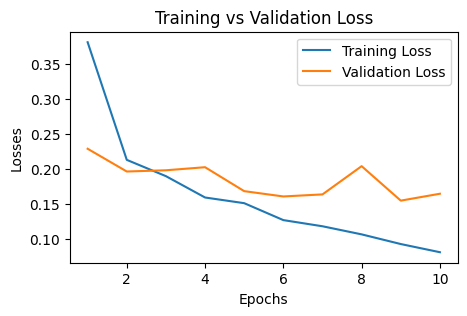

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Training the model
#partially adapted from the Lab
best_val_loss = 100 # highest can be 100% so using 100 to compare
state_dict_best_model = None
loss_train = []
loss_val = []
patience = 5  # num epochs to wait for improvement
counter_earlyStop = 0

for epoch in range(epochs):
    net.train()
    total_batch_loss = 0.0
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = net(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_batch_loss =total_batch_loss+ loss.item()

    #average training loss for the epoch
    epoch_loss_train = total_batch_loss / len(train_dataloader)
    loss_train.append(epoch_loss_train)
    print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {epoch_loss_train:.2f}")

    # perform validation
    net.eval()
    total_batch_loss_val = 0.0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            #feed  forward
            outputs = net(images)
            loss = criterion(outputs, labels)
            total_batch_loss_val =total_batch_loss_val+ loss.item()

    # store training and validation loss
    epoch_loss_val = total_batch_loss_val / len(val_dataloader)
    loss_val.append(epoch_loss_val)
    print(f"Epoch [{epoch+1}/{epochs}], Validation Loss: {epoch_loss_val:.2f}")

    # save best model with least validation loss
    if epoch_loss_val < best_val_loss:
        best_val_loss = epoch_loss_val
        state_dict_best_model = net.state_dict()

        early_stop_counter = 0  # reset counter to 0 if the performance improved in 5 epochs
    else:
        counter_earlyStop =counter_earlyStop + 1
        if counter_earlyStop >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Save the best model
if state_dict_best_model is not None:
  print('Best Model')
    #save best model
  torch.save(net.state_dict(), 'drive/My Drive/My_Computer_vision/CV_Coursework/CW_Folder_PG_template/CW_Folder_PG/Models/cnn_best_model_final.pth')

# plot trainig and validation loss for each epochs
epochs_range = range(1, len(loss_train) + 1)
plt.figure(figsize=(5, 3))
plt.plot(epochs_range, loss_train, label='Training Loss')
plt.plot(epochs_range, loss_val, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

In [ ]:
# evalute results on test data
net.eval()
with torch.no_grad():
        y_predict = []
        y = []
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            y_predict.extend(predicted.cpu().numpy())
            y.extend(labels.cpu().numpy())

        test_acc = accuracy_score(y, y_predict)
        print(f"Test Accuracy is {test_acc *100:.2f}%")

Test Accuracy is 94.10%


In [ ]:
print(device) #check device

cpu


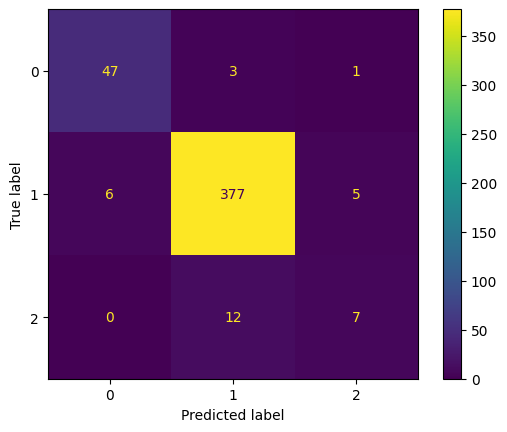

In [ ]:
metrics.ConfusionMatrixDisplay.from_predictions(y, y_predict)
plt.show() #confusin metrics (to compare differnece in true and predicted labels)

In [ ]:
#Verify load model and test the same results
model_path = "drive/My Drive/My_Computer_vision/CV_Coursework/CW_Folder_PG_template/CW_Folder_PG/Models/cnn_best_model_final.pth"

In [ ]:
state_dict = torch.load(model_path) #load the dict from the model ( weights and biases got during modelling)

In [ ]:
#Define the network again which will be required for dict mentioned above
class mask_Net(nn.Module):
    def __init__(self):
        super(mask_Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels= 3,out_channels= 32,kernel_size= 3, padding =1) #first convolution layer
        self.pool = nn.MaxPool2d(kernel_size=2,stride= 2)# defined maxpooled layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding =1)#second convolution layer

        self.fc1 = nn.Linear(64*32*32, 64)  # input size of 1st fully connected layer
        self.fc2 = nn.Linear(64, 64) #2nd fully connected layer
        self.fc3 = nn.Linear(64, 3) #output layer with 3 (number of classes are three)

    def forward(self, x): #feed forward network defined
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor for using in fully connected network
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net_test = mask_Net().to(device)

In [ ]:
net_test.load_state_dict(state_dict) #load dict (we got the model to test)

<All keys matched successfully>

In [ ]:
# evaluation onntest data
net_test.eval()
with torch.no_grad():
        y_predict = []
        y = []
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            y_predict.extend(predicted.cpu().numpy())
            y.extend(labels.cpu().numpy())

        test_acc = accuracy_score(y, y_predict)
        print(f"Test Accuracy is {test_acc *100:.2f}%")

Test Accuracy is 94.10%


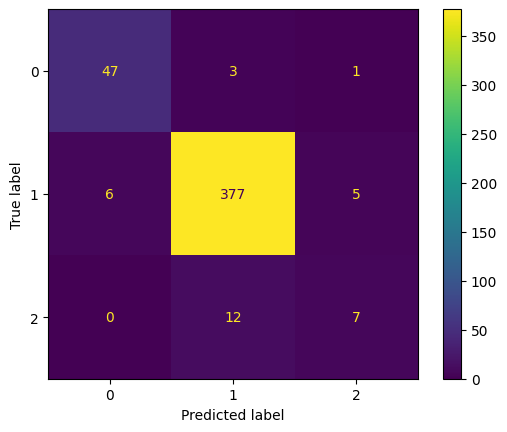

In [ ]:
metrics.ConfusionMatrixDisplay.from_predictions(y, y_predict)
plt.show() # confirming cofusion matrix

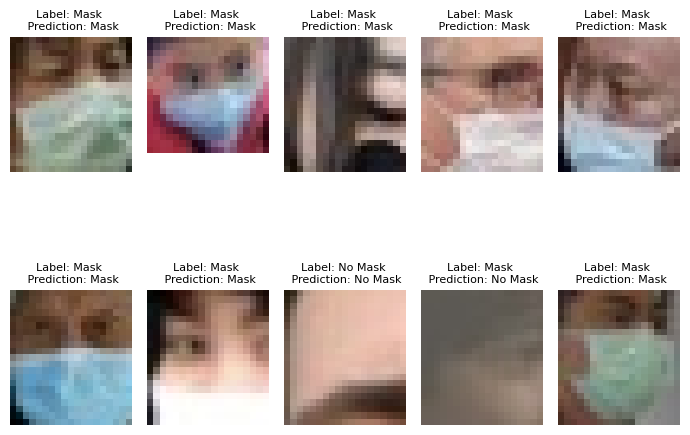

In [ ]:
#display 10 images with their true and predicted labels
#Code partially adapted from Lab
images, label, y = shuffle(test_loader.dataset.inputs, y, y_predict)
fig, axes = plt.subplots(2, 5, figsize=(7, 6), sharex=True, sharey=True)
ax = axes.ravel()
dict = {1: 'Mask', 2: 'Incorrect Mask', 0: 'No Mask'}


for i in range(10):
    ax[i].imshow(images[i])
    ax[i].set_title(f'Label: {dict[label[i]]} \n Prediction: {dict[y[i]]}', fontsize =8)
    ax[i].set_axis_off()
fig.tight_layout()
plt.show()

In [ ]:
#Performance metrics of different class labels
print(f"""Classification report for classifier {net_test}:
      {metrics.classification_report(y, y_predict)}\n""")

Classification report for classifier mask_Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=65536, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
):
                    precision    recall  f1-score   support

           0       0.89      0.92      0.90        51
           1       0.96      0.97      0.97       388
           2       0.54      0.37      0.44        19

    accuracy                           0.94       458
   macro avg       0.80      0.75      0.77       458
weighted avg       0.94      0.94      0.94       458




In [ ]:
from sklearn.metrics import accuracy_score,recall_score,precision_score, f1_score

In [ ]:
#Weighted performance metrics for three label class
print(f'Accuracy: {accuracy_score(y, y_predict)}')
print(f'F1 score: {f1_score(y, y_predict, average="weighted")}')
print(f'recall: {recall_score(y, y_predict,average="weighted")}')
print(f'precision:{precision_score(y, y_predict,average="weighted")}')

Accuracy: 0.9410480349344978
F1 score: 0.9377190404210056
recall: 0.9410480349344978
precision:0.935830230457639


In [ ]:
#-------------------------------------------------------CNN Code and model--------------------------------------------------#